In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=[]

env: CUDA_VISIBLE_DEVICES=[]


### Humpback Whale vocalizations
Source:
- https://www.mobysound.org/
- http://localhost:8186/tree/Datasets/mobysound/humpback-01

In [2]:
from pathlib2 import Path
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
from tqdm.autonotebook import tqdm
from librosa.core.time_frequency import mel_frequencies
from avgn_paper.signalprocessing.spectrogramming_tf import spectrogram_tensorflow
from avgn_paper.utils.audio import load_wav, float32_to_int16, int16_to_float32, write_wav
from avgn_paper.visualization.spectrogram import visualize_spec, plot_spec
from avgn_paper.utils.general import HParams

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### data locations

In [4]:
DSLOC = Path('/mnt/cube/Datasets/mobysound/humpback-01/')
readme = DSLOC/'README-humpback-1.txt'
readme = [line for line in open(readme, 'r')]  

In [5]:
rate = 4000

In [6]:
#print(''.join(readme))

In [7]:
wavs = list(DSLOC.glob('*.wav'))
labels = list(DSLOC.glob('*.box'))

### load labels

In [8]:
all_labels = []
for label_file in labels:
    label_df = pd.DataFrame(
        [line.split() for line in open(label_file, "r")],
        columns=["start-time", "end-time", "low-freq", "high-freq", "SNR"],
    )
    label_df['file'] = label_file.stem
    all_labels.append(label_df)
all_labels = pd.concat(all_labels).reset_index()
all_labels['st_samp'] = (all_labels['start-time'].values.astype('float32')*rate).astype('int')
all_labels['et_samp'] = (all_labels['end-time'].values.astype('float32')*rate).astype('int')

In [9]:
print(len(all_labels))
all_labels[:3]

2310


index start-time end-time low-freq  high-freq          SNR         file  \
0      0       1.00     2.67  28.6175  1996.0701  2.31046e+01  940305-1007   
1      1       4.60     5.94  71.5437  2024.6875  3.41566e+01  940305-1007   
2      2       6.43     8.20  21.4631  2003.2244  3.65054e+01  940305-1007   

   st_samp  et_samp  
0     4000    10680  
1    18400    23760  
2    25720    32800

### load wav

In [10]:
wav_ds = pd.DataFrame(columns = ['rate', 'data', 'file'])
for wav_loc in wavs:
    rate, data = load_wav(wav_loc)
    wav_ds.loc[len(wav_ds)] = [rate, data, wav_loc.stem]

In [11]:
wav_ds[:3]

rate                                               data         file
0  4000  [9, -17, 86, 262, 337, 417, 335, 220, -86, -24...  940302-1222
1  4000  [45, -129, 783, 1287, -1432, -794, -1134, -181...  940305-1007
2  4000  [-22, 62, 5939, 5764, 5112, 331, -30, 74, 7, -...  940302-1322

### Get spectrogram parameters

In [12]:
win_length_ms = 100
hop_length_ms = 20
print(win_length_ms/1000*rate)
hparams = HParams(  
    # spectrogramming
    win_length = int(rate/1000 * win_length_ms),
    n_fft = 2048,
    hop_length= int(rate/1000 * hop_length_ms),
    ref_level_db = 20,
    min_level_db = -40,
    # mel scaling
    num_mel_bins = 64,
    mel_lower_edge_hertz = 0,
    mel_upper_edge_hertz = 2000,
    # inversion
    power = 1.5, # for spectral inversion
    griffin_lim_iters = 50,
    pad=True,
    #
)

# create a filter to convolve with the spectrogram
mel_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=hparams.num_mel_bins,
    num_spectrogram_bins=int(hparams.n_fft/2)+1,
    sample_rate=rate,
    lower_edge_hertz=hparams.mel_lower_edge_hertz,
    upper_edge_hertz=hparams.mel_upper_edge_hertz,
    dtype=tf.dtypes.float32,
    name=None,
)
# gets the center frequencies of mel bands
mel_f = mel_frequencies(
    n_mels=hparams.num_mel_bins + 2,
    fmin=hparams.mel_lower_edge_hertz,
    fmax=hparams.mel_upper_edge_hertz,
)
# Slaney-style mel is scaled to be approx constant energy per channel (from librosa)
enorm = tf.dtypes.cast(
    tf.expand_dims(tf.constant(2.0 / (mel_f[2 : hparams.num_mel_bins + 2] - mel_f[:hparams.num_mel_bins])), 0),
    tf.float32,
)
mel_matrix = tf.multiply(mel_matrix, enorm)
mel_matrix = tf.divide(mel_matrix, tf.reduce_sum(mel_matrix, axis=0))

400.0


### plot a bout

In [13]:
data = wav_ds.data.values[0]

In [14]:
spectrogram = spectrogram_tensorflow(int16_to_float32(data), hparams)

In [15]:
mel_spectrogram = tf.tensordot(spectrogram,mel_matrix, 1)

In [16]:
np.shape(mel_spectrogram)

TensorShape([45108, 64])

(-0.5, 45107.5, -0.5, 63.5)

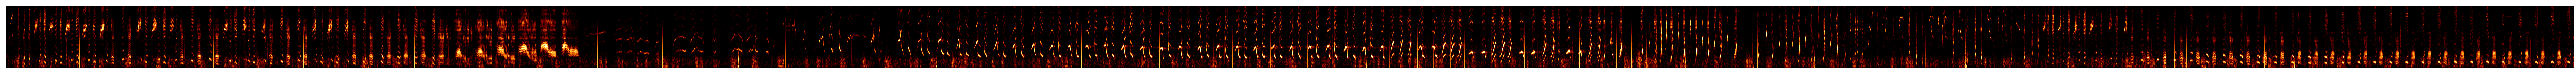

In [17]:
fig, ax = plt.subplots(figsize=(200,5))
ax.matshow(mel_spectrogram.numpy().T, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
ax.axis('off')

### grab individual syllables

In [18]:
nex = 5
syllable = all_labels.loc[nex]
syll_wav = wav_ds[wav_ds.file == syllable.file].data.values[0][syllable.st_samp:syllable.et_samp]
spectrogram = spectrogram_tensorflow(int16_to_float32(syll_wav), hparams)


mel_spectrogram = tf.tensordot(spectrogram,mel_matrix, 1)

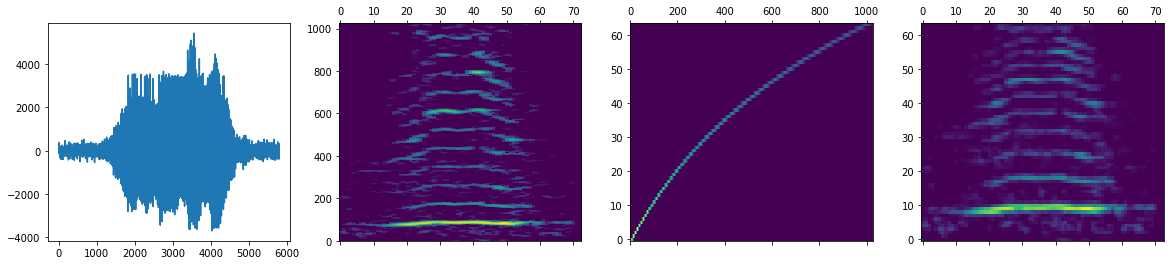

In [19]:
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
axs[0].plot(syll_wav)
plot_spec(spectrogram.numpy().T,cmap = plt.cm.viridis, fig=fig, ax = axs[1], show_cbar=False)
plot_spec(mel_matrix.numpy().T,cmap = plt.cm.viridis, fig=fig, ax = axs[2], show_cbar=False)
plot_spec(mel_spectrogram.numpy().T,cmap = plt.cm.viridis, fig=fig, ax = axs[3], show_cbar=False)

### make syllable for each label

In [20]:
from joblib import Parallel, delayed
n_jobs = 10
verbosity = 5

In [21]:
def make_spec(syll_wav, mel_matrix, hparams):
    spectrogram = spectrogram_tensorflow(int16_to_float32(syll_wav), hparams)
    mel_spectrogram = tf.tensordot(spectrogram,mel_matrix, 1)
    return mel_spectrogram.numpy().T

from PIL import Image 
def log_resize_spec(spec):
    resize_shape = [int(np.log(np.shape(spec)[1])*10), 64]
    resize_spec = Image.fromarray(spec).resize(resize_shape, Image.ANTIALIAS)
    return resize_spec
def pad_spectrogram(spectrogram, pad_length):
    """ Pads a spectrogram to being a certain length
    """
    excess_needed = pad_length - np.shape(spectrogram)[1]
    pad_left = np.floor(float(excess_needed) / 2).astype("int")
    pad_right = np.ceil(float(excess_needed) / 2).astype("int")
    return np.pad(
        spectrogram, [(0, 0), (pad_left, pad_right)], "constant", constant_values=0
    )

In [22]:
with Parallel(n_jobs=24, verbose=verbosity) as parallel:
    mel_specs = parallel(
        delayed(make_spec)(
            wav_ds[wav_ds.file == syllable.file].data.values[0][
                syllable.st_samp : syllable.et_samp
            ],
            mel_matrix,
            hparams
        )
        for idx, syllable in tqdm(all_labels.iterrows(), total=len(all_labels))
    )
    mel_specs = [i/np.max(i) for i in mel_specs]
    specs_smaller = parallel(delayed(log_resize_spec)(spec) for spec in tqdm(mel_specs))
    spec_lens = [np.shape(i)[1] for i in specs_smaller]
    specs_padded = parallel(
        delayed(pad_spectrogram)(spec, np.max(spec_lens))
        for spec in tqdm(specs_smaller)
    )
all_labels["spec"] = specs_padded

[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  24 tasks      | elapsed:   12.4s
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:   12.7s
[Parallel(n_jobs=24)]: Done 481 tasks      | elapsed:   14.0s
[Parallel(n_jobs=24)]: Done 1129 tasks      | elapsed:   15.4s
[Parallel(n_jobs=24)]: Done 1921 tasks      | elapsed:   17.3s


[Parallel(n_jobs=24)]: Done 2310 out of 2310 | elapsed:   18.2s finished


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  24 tasks      | elapsed:    0.0s


[Parallel(n_jobs=24)]: Done 2310 out of 2310 | elapsed:    0.3s finished


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.


[Parallel(n_jobs=24)]: Done 2310 out of 2310 | elapsed:    1.4s finished


### plot spectrograms

In [23]:
nrow = 30
ncol = 30
dimx = np.shape(specs_padded[0])[0]
dimy = np.shape(specs_padded[0])[1]
print(nrow*ncol)

canvas = np.zeros((nrow*dimx, ncol*dimy))
cn = 0
for row in range(nrow)[::-1]:
    for col in range(ncol):
        canvas[dimx*row:dimx*(row+1), dimy*col:dimy*(col+1)] = specs_padded[cn]
        cn += 1

900


(-0.5, 1829.5, -0.5, 1919.5)

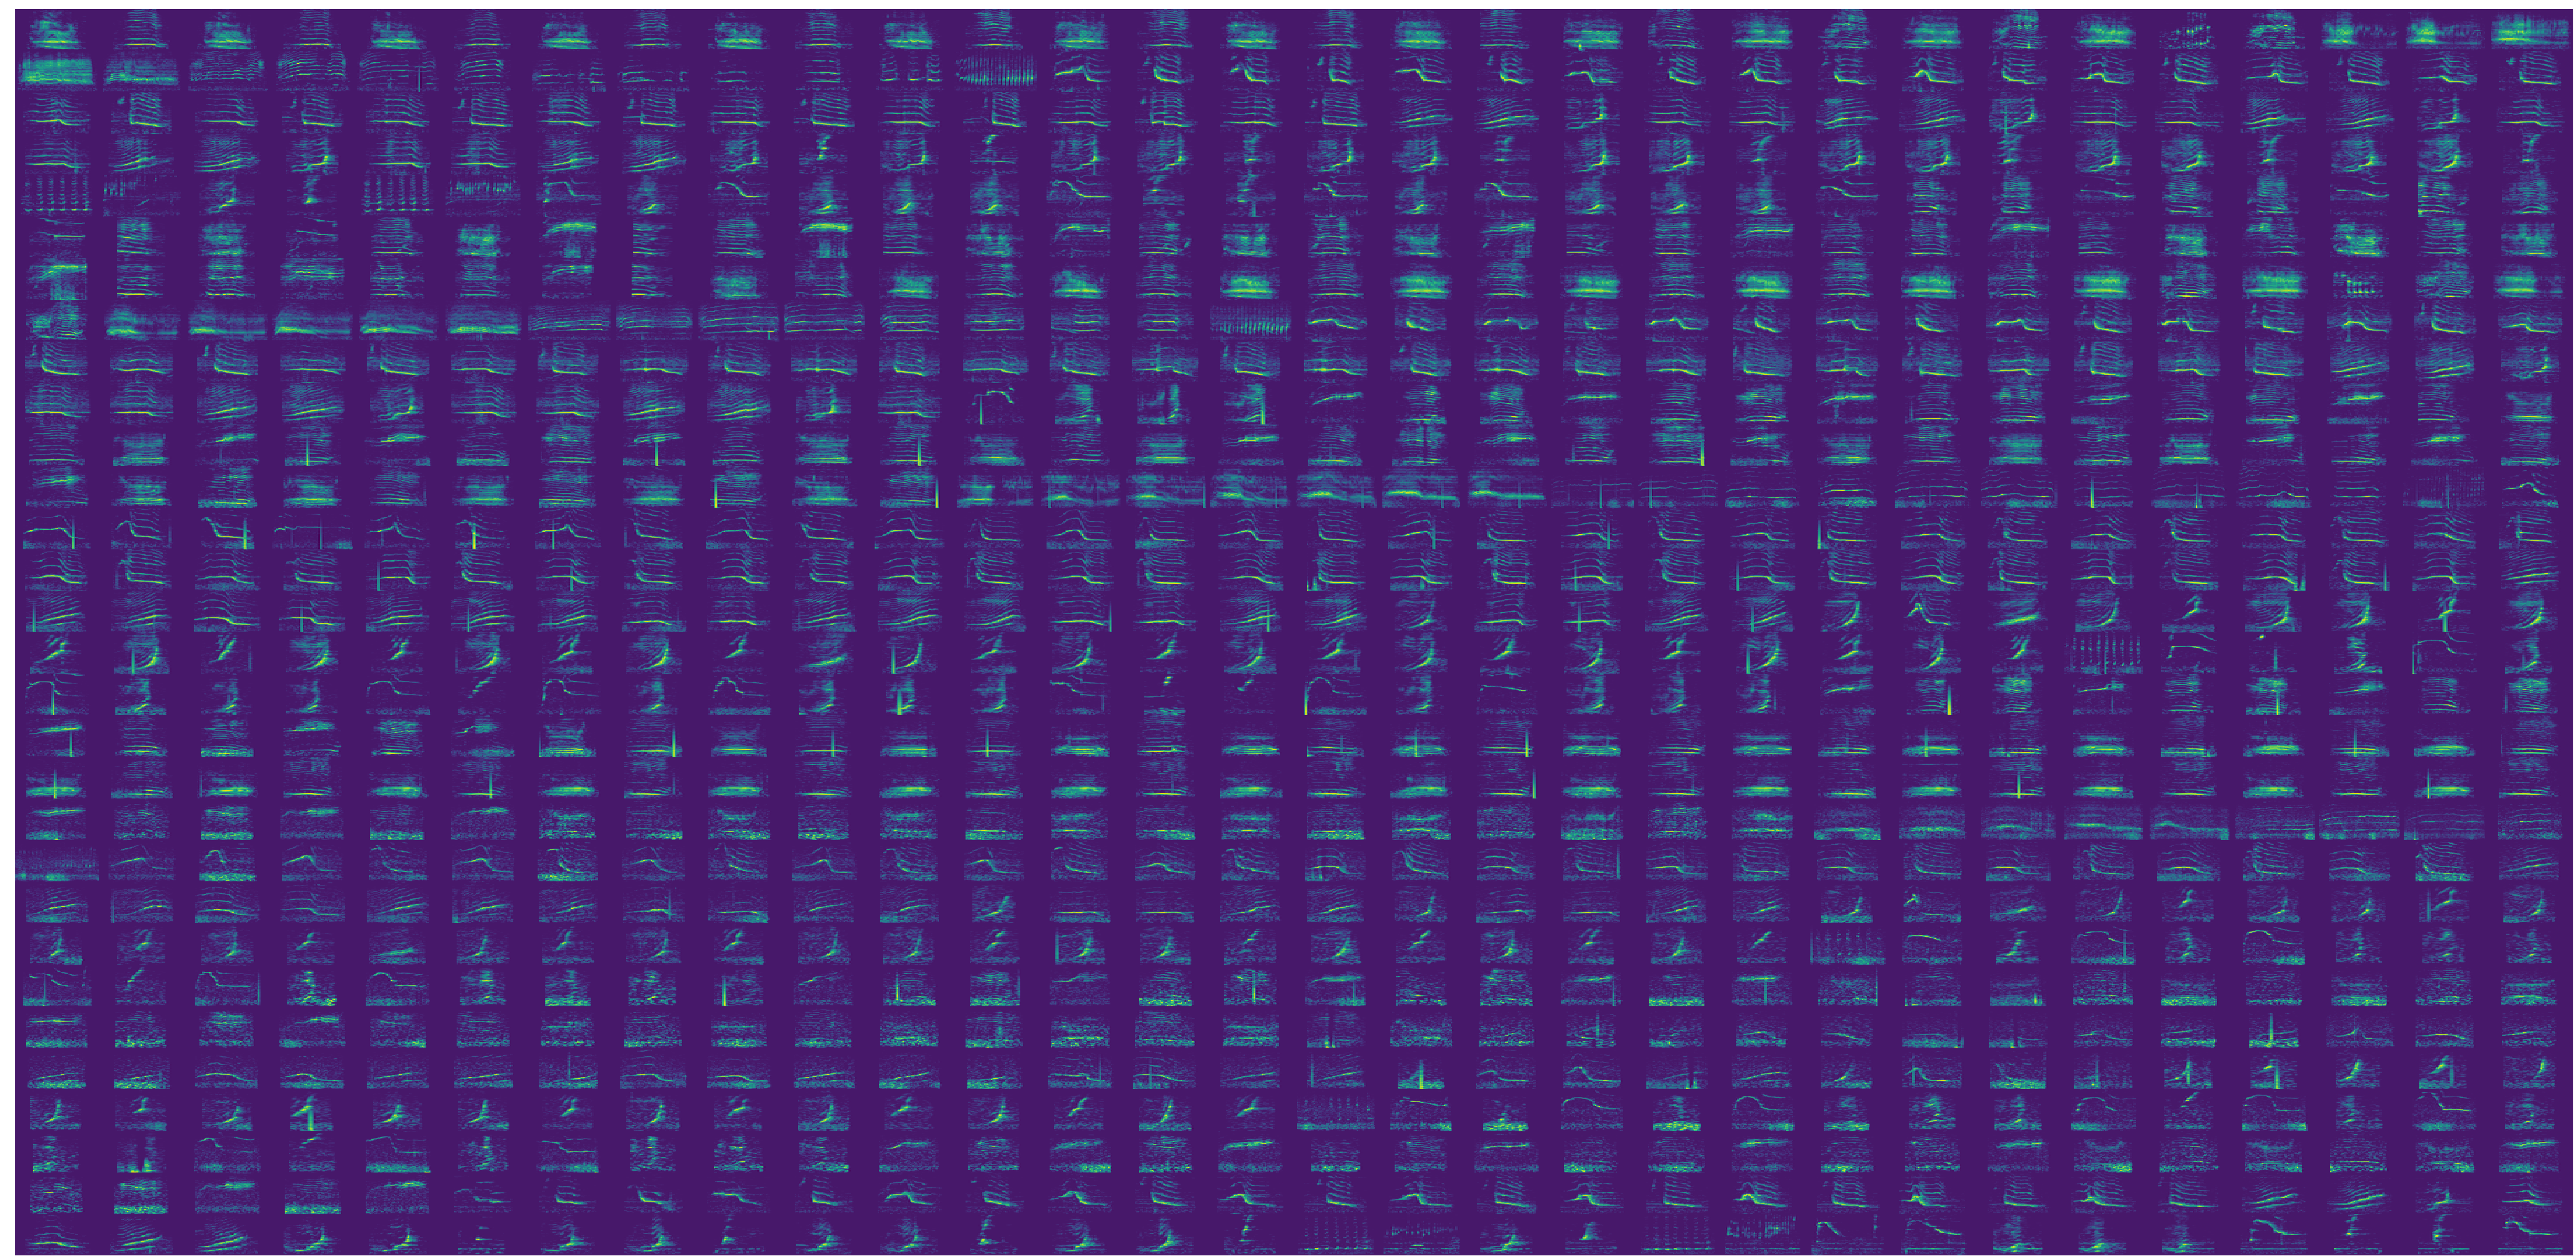

In [24]:
zoom = 2
fig, ax = plt.subplots(figsize=(ncol*zoom*2, nrow*zoom))
ax.matshow(canvas, origin='lower', aspect='auto', cmap = plt.cm.viridis)
ax.axis('off')

### UMAP projections

In [25]:
all_labels[:3]

index start-time end-time low-freq  high-freq          SNR         file  \
0      0       1.00     2.67  28.6175  1996.0701  2.31046e+01  940305-1007   
1      1       4.60     5.94  71.5437  2024.6875  3.41566e+01  940305-1007   
2      2       6.43     8.20  21.4631  2003.2244  3.65054e+01  940305-1007   

   st_samp  et_samp                                               spec  
0     4000    10680  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1    18400    23760  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
2    25720    32800  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

In [26]:
import umap

In [27]:
specs_flattened = np.reshape(specs_padded, (np.shape(specs_padded)[0], np.prod(np.shape(specs_padded)[1:])))
len(specs_flattened)

2310

In [28]:
fit = umap.UMAP(min_dist=0.25)
%time u_all = fit.fit_transform(specs_flattened)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


CPU times: user 21.1 s, sys: 1.12 s, total: 22.2 s
Wall time: 14.7 s


In [29]:
all_labels[:3]

index start-time end-time low-freq  high-freq          SNR         file  \
0      0       1.00     2.67  28.6175  1996.0701  2.31046e+01  940305-1007   
1      1       4.60     5.94  71.5437  2024.6875  3.41566e+01  940305-1007   
2      2       6.43     8.20  21.4631  2003.2244  3.65054e+01  940305-1007   

   st_samp  et_samp                                               spec  
0     4000    10680  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1    18400    23760  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
2    25720    32800  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

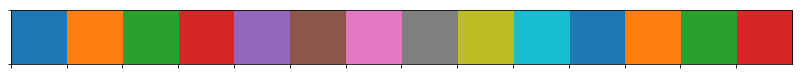

In [30]:
import seaborn as sns
labs = all_labels.file.values
pal = sns.color_palette(n_colors=len(np.unique(labs)))
sns.palplot(pal)
lab_dict = {lab:pal[i] for i, lab in enumerate(np.unique(labs))}
colors = np.array([lab_dict[i] for i in labs])

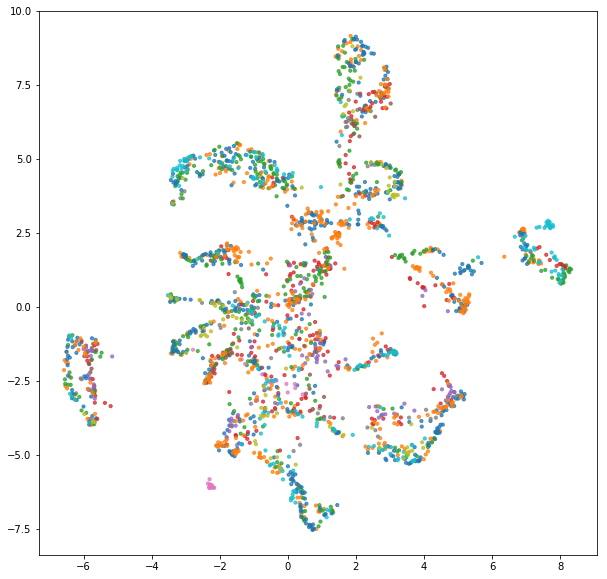

In [31]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(u_all[:,0], u_all[:,1], alpha = 0.75, s=10, color=colors)

In [32]:
colors = all_labels.st_samp.values/np.max(all_labels.st_samp.values)

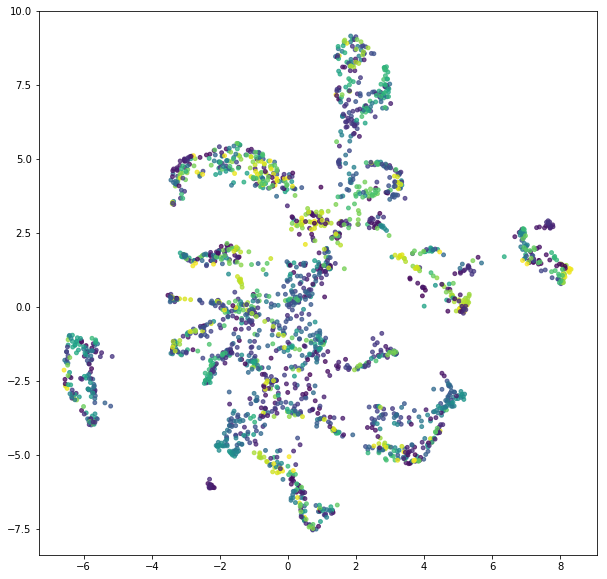

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(u_all[:,0], u_all[:,1], alpha = 0.75, s=15, c=colors)

### UMAP of a single song

In [34]:
all_labels[:3]

index start-time end-time low-freq  high-freq          SNR         file  \
0      0       1.00     2.67  28.6175  1996.0701  2.31046e+01  940305-1007   
1      1       4.60     5.94  71.5437  2024.6875  3.41566e+01  940305-1007   
2      2       6.43     8.20  21.4631  2003.2244  3.65054e+01  940305-1007   

   st_samp  et_samp                                               spec  
0     4000    10680  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1    18400    23760  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
2    25720    32800  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

In [35]:
song_lengths = pd.DataFrame({i:[np.sum(all_labels.file.values == i)] for i in np.unique(all_labels.file.values)})
song_lengths

940302-1222  940302-1237  940302-1307  940302-1322  940302-1331  \
0          289          277          108          167           83   

   940302-1338  940305-0852  940305-0907  940305-0921  940305-0937  \
0           52           29           56           83          205   

   940305-0952  940305-1007  940305-1022  940305-1037  
0          308          281          304           68

In [36]:
song_name = '940305-1007'
song_specs = specs_flattened[all_labels.file.values == song_name]
song_labs = all_labels[all_labels.file.values == song_name]

In [37]:
len(song_specs), len(song_labs)

(281, 281)

In [38]:
song_labs[:3]

index start-time end-time low-freq  high-freq          SNR         file  \
0      0       1.00     2.67  28.6175  1996.0701  2.31046e+01  940305-1007   
1      1       4.60     5.94  71.5437  2024.6875  3.41566e+01  940305-1007   
2      2       6.43     8.20  21.4631  2003.2244  3.65054e+01  940305-1007   

   st_samp  et_samp                                               spec  
0     4000    10680  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1    18400    23760  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
2    25720    32800  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

In [39]:
fit = umap.UMAP(min_dist=0.1, metric = 'euclidean')
%time u = fit.fit_transform(song_specs)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


CPU times: user 3.03 s, sys: 244 ms, total: 3.27 s
Wall time: 893 ms


In [40]:
colors = song_labs.st_samp.values/np.max(song_labs.st_samp.values)

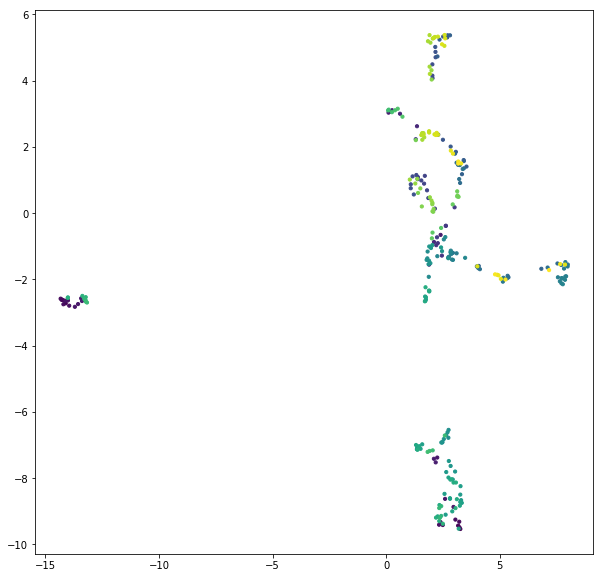

In [41]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(u[:,0], u[:,1], alpha = 1, s=10, c = colors)

### Plot ordering of songs

### Segmentation using thresholding

### background noise reduction example in pipeline